# Toronto Dwellings Analysis Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions to create a Panel dashboard.

In [33]:
# initial imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import panel as pn
import plotly.express as px
from pathlib import Path
from dotenv import load_dotenv
from matplotlib.figure import Figure
import hvplot.pandas


In [34]:
# Initialize the Panel Extensions (for Plotly)

pn.extension("plotly")


In [35]:
import pandas_bokeh
pandas_bokeh.output_notebook()
# imported pandas_bokeh to print certain bar graphs in bokeh as matplotlib was not working

Loading BokehJS ...

In [36]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)
print(map_box_api)

pk.eyJ1IjoibXVuaXBhbGxlYSIsImEiOiJja2Mya2ZzcjQwMzc0MnZwM3VlM3dtMjJoIn0.9KD4_zGnIPyuI9b8CD6KFQ


# Import Data

In [37]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/toronto_neighbourhoods_census_data.csv")
to_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/toronto_neighbourhoods_coordinates.csv")
df_neighbourhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

### Global available data

In [38]:
# Getting the data from the top 10 expensive neighbourhoods. Coded as average across all years.
Top10Neighborhood=to_data.groupby(['neighbourhood']).mean().sort_values(by=['average_house_value'],ascending=False).head(10)

# Calculate the mean number of dwelling types units per year
NewDF7=to_data.reset_index()
NewDF7['average dwelling']=NewDF7.iloc[:,2:10].mean(axis=1)
MeanByYear=NewDF7[['year','average dwelling']].groupby(by='year').mean()
MeanByYear.head()

# Calculate the average monthly shelter costs for owned and rented dwellings
ShelterCosts=NewDF7[['year','shelter_costs_owned','shelter_costs_rented']].groupby(by='year').mean()

df_dwelling_units=to_data[['single_detached_house','apartment_five_storeys_plus','movable_dwelling','semi_detached_house','row_house','duplex','apartment_five_storeys_less','other_house']].groupby(by='year').sum()

# Two additional global variables to produce neighbourhood / year bar graph
TempDF=to_data.reset_index()
TempDF2=TempDF.iloc[:,:10]


### Panel Visualization Functions

In [39]:
# Define Panel visualization functions
def neighbourhood_map():
    MeanValuesNeighbourhood=to_data.groupby(by='neighbourhood').mean().reset_index()
    JoinedDF=df_neighbourhood_locations.merge(MeanValuesNeighbourhood, on="neighbourhood", how = 'inner')
    neigh_map = px.scatter_mapbox(JoinedDF, lat="lat", lon="lon",color="average_house_value", size="average_house_value",hover_name='neighbourhood',
                        hover_data=['shelter_costs_owned', 'shelter_costs_rented','single_detached_house', 'apartment_five_storeys_plus', 'movable_dwelling',
       'semi_detached_house', 'row_house', 'duplex','apartment_five_storeys_less', 'other_house','lat', 'lon'],
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
    return neigh_map

def create_bar_chart(data, title, xlabel, ylabel, color):
    mpl_fig = plt.figure()
    mpl_fig=data.plot.bar(title=title,color=color[0])
    #ax = fig.subplots()
    #ax=data.plot.bar(title=title,color=color[0])
    mpl_fig.set_xlabel(xlabel)
    mpl_fig.set_ylabel(ylabel)
    #ax.set_xlabel(xlabel)
    #ax.set_ylabel(ylabel)
    return mpl_fig
    
    
def create_line_chart(data, title, xlabel, ylabel, color):
    mpl_fig1=plt.figure()
    mpl_fig1=data.plot.line(title=title,color=color[0])
    mpl_fig1.set_xlabel(xlabel)
    mpl_fig1.set_ylabel(ylabel)
    return mpl_fig1

# Created another bokeh based line chart as Matplotlib version is not loading
def create_line_chart_bokeh(data, title, xlabel, ylabel, color):
    colourmap=[]
    colourmap.append(color)
    mpl_fig1=data.plot_bokeh(
    kind="line",
    figsize=(500, 250),
    title=title,
    xlabel=xlabel,
    ylabel=ylabel,
    toolbar_location=None,
    colormap=colourmap,
    legend= "top_left",
    panning=False,
    zooming=False)
    return mpl_fig1

def average_house_value():
    NewDF4=to_data['average_house_value'].groupby(by='year').mean()
    ax2=NewDF4.plot.line(title="Average House Value in Toronto",color='b')
    ax2.set_xlabel("Year")
    ax2.set_ylabel("Avg. House Value")
    return ax2

# Created another bokeh based line chart as Matplotlib version is not loading
def average_house_value_bokeh():
    NewDF4=to_data['average_house_value'].groupby(by='year').mean()
    ax2=NewDF4.plot_bokeh(kind="line",figsize=(500, 250),title="Average House Value in Toronto",xlabel="Year",
                          ylabel="Avg. House Value",legend= "top_left",disable_scientific_axes="y",colormap=['blue'])
    return ax2


def average_value_by_neighbourhood():
    NewDF5=to_data[['neighbourhood','average_house_value']].groupby(['year','neighbourhood']).mean().reset_index()
    avg_value_neighbourhood=NewDF5.hvplot.line(x='year',y='average_house_value',
                                               groupby='neighbourhood',value_label='Average House by Neighborhood',
                                               ylim=(100000, 2200000)).opts(framewise=True,yformatter='$%.2f')
    return avg_value_neighbourhood
    

def number_dwelling_types():
    #used NewDF7 created in global data
    num_dwelling_hvplot=TempDF2.groupby(['year','neighbourhood','single_detached_house','apartment_five_storeys_plus',
                                         'movable_dwelling','semi_detached_house','row_house','duplex','apartment_five_storeys_less',
                                         'other_house']).sum().hvplot.bar(stacked=False,groupby='neighbourhood',height=500,rot=90)
    return num_dwelling_hvplot                                                                                                              

def average_house_value_snapshot():
    BarFacetDF=to_data[['neighbourhood','average_house_value']].reset_index()
    fig = px.bar(BarFacetDF,x='neighbourhood', y="average_house_value", color="average_house_value",facet_row="year")
    return fig

def top_most_expensive_neighbourhoods():
    top_10_bar=Top10Neighborhood.hvplot.bar(y='average_house_value',height=500,rot=90).opts(framewise=True,yformatter='$%.2f')
    return top_10_bar

# Replace matplotlib with bokeh for the dwellings graphs as matplotlib was not printing
def create_bar_chart_bokeh(data, title, xlabel, ylabel, color):
    colormap=[]
    colormap.append(color)
    ax=data.plot_bokeh(
    kind='bar',
    xlabel=xlabel,
    ylabel=ylabel,
    vertical_xlabel=True,
    title=title,
    figsize=(800, 400),
    colormap=colormap,
    disable_scientific_axes="y")
    return ax

def sunburts_cost_analysis():
    ExpensiveDF_subset=to_data[['neighbourhood','average_house_value']]
    df_agg = to_data.groupby(['year','neighbourhood','shelter_costs_owned','shelter_costs_rented']).agg({'average_house_value':sum})
    g = df_agg['average_house_value'].groupby(level=0, group_keys=False)
    testdf=g.nlargest(10)
    idx=testdf.index
    data = {'neighbourhood':idx.get_level_values(1), 'shelter_costs_owned':idx.get_level_values(2),
            'shelter_costs_rented':idx.get_level_values(3),'average_home_value':testdf.values} 
    ExpensiveDF=pd.DataFrame(data=data,index=idx.get_level_values(0))
    ExpensiveDF=ExpensiveDF.reset_index()
    sunburst_exp_plot = px.sunburst(ExpensiveDF, path=['year','neighbourhood'], values='average_home_value',
                  color='shelter_costs_owned', hover_data=['shelter_costs_owned','shelter_costs_rented'],
                  color_continuous_scale='ice'
                  )
    return sunburst_exp_plot

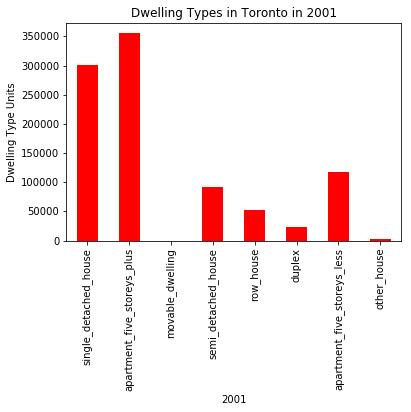

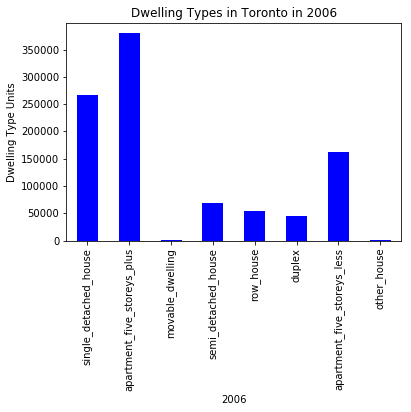

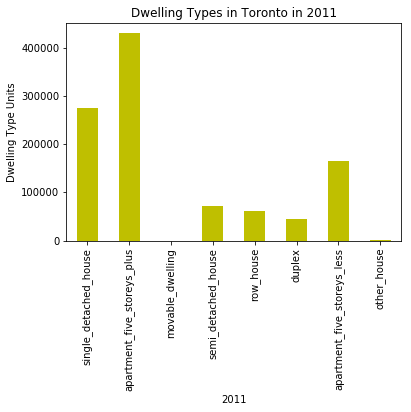

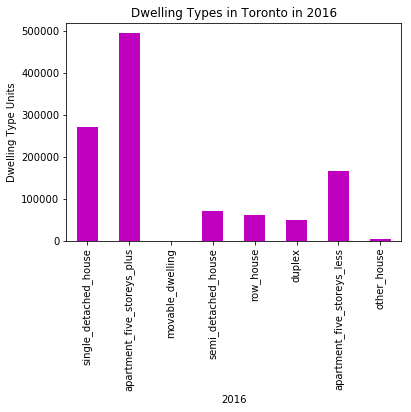

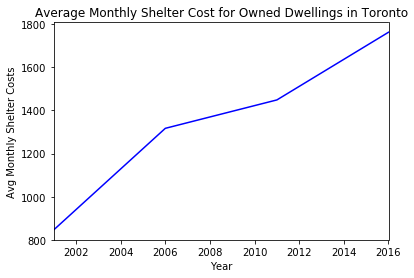

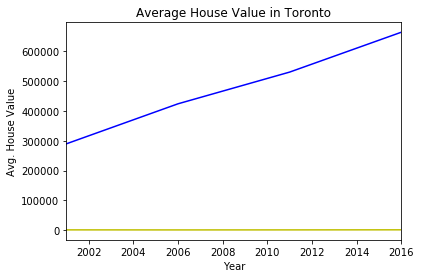

In [40]:
#Toronto (tab name)
jpg_path= Path("toronto.jpg")
pane_image=pn.panel('toronto.jpg')
TorontoRow=pn.Row("#I love Toronto. It's a real melting pot in every sense of the word. There's all sorts of different people everywhere you go. There's all sorts of great music, great restaurants and great night spots. - PRINCE",pane_image)

#Welcome (tab name)
pane_welcome=pn.panel(neighbourhood_map())
WelcomeRow=pn.Row("##Welcome to Toronto",pane_welcome)


#Top Expensive Neighbourhoods (tab name)
pane_expensive=pn.panel(top_most_expensive_neighbourhoods())
pane_sunburst=pn.panel(sunburts_cost_analysis())
NeighbourhoodRow=pn.Column("#Top Most Expensive Neighbourhoods",pane_expensive,pane_sunburst)



#Yearly Market Analysis (not used)
pane_2001=pn.panel(create_bar_chart(df_dwelling_units.loc[2001], "Dwelling Types in Toronto in 2001", "2001", "Dwelling Type Units", "red"))
pane_2006=pn.panel(create_bar_chart(df_dwelling_units.loc[2006], "Dwelling Types in Toronto in 2006", "2006", "Dwelling Type Units", "blue"))
pane_2011=pn.panel(create_bar_chart(df_dwelling_units.loc[2011], "Dwelling Types in Toronto in 2011", "2011", "Dwelling Type Units", "yellow"))
pane_2016=pn.panel(create_bar_chart(df_dwelling_units.loc[2016], "Dwelling Types in Toronto in 2016", "2016", "Dwelling Type Units", "magenta"))
YearlyMarketRow1=pn.Row("##2001 and 2006 Data",pane_2001,pane_2006)
YearlyMarketRow2=pn.Row("##2011 and 2016 Data",pane_2011,pane_2016)
FinalYearlyMarketColumn=pn.Column("#Price Trends 2001,2006,2011 and 2016",YearlyMarketRow1,YearlyMarketRow2)

#Yearly Market Analysis Bokeh (tab name)
pane_2001_bokeh=pn.panel(create_bar_chart_bokeh(df_dwelling_units.loc[2001], "Dwelling Types in Toronto in 2001", "2001", "Dwelling Type Units", "red"))
pane_2006_bokeh=pn.panel(create_bar_chart_bokeh(df_dwelling_units.loc[2006], "Dwelling Types in Toronto in 2006", "2006", "Dwelling Type Units", "blue"))
pane_2011_bokeh=pn.panel(create_bar_chart_bokeh(df_dwelling_units.loc[2011], "Dwelling Types in Toronto in 2011", "2011", "Dwelling Type Units", "yellow"))
pane_2016_bokeh=pn.panel(create_bar_chart_bokeh(df_dwelling_units.loc[2016], "Dwelling Types in Toronto in 2016", "2016", "Dwelling Type Units", "magenta"))
YearlyMarketRow1_bokeh=pn.Row(pane_2001_bokeh,pane_2006_bokeh)
YearlyMarketRow2_bokeh=pn.Row(pane_2011_bokeh,pane_2016_bokeh)
FinalYearlyMarketColumn_bokeh=pn.Column("##Price Trends 2001,2006,2011 and 2016",YearlyMarketRow1_bokeh,YearlyMarketRow2_bokeh)

#Neighbourhood Analysis (tab name)
pane_facet_graph=pn.panel(average_house_value_snapshot())
pane_top10_Neighbourhoods=pn.panel(top_most_expensive_neighbourhoods())
pane_dwelling_types=pn.panel(number_dwelling_types())
pane_avg_value_neighbourhood=pn.panel(average_value_by_neighbourhood())
NeighbourhoodCol1=pn.Column("# Average Price ",pane_facet_graph)
NeighbourhoodCol2=pn.Column(pane_dwelling_types,pane_avg_value_neighbourhood)
Final_Neighbourhood=pn.Column(NeighbourhoodCol2,NeighbourhoodCol1)

#Shelter costs vs. House Value (not used in panel)
pane_shelter=pn.panel(create_line_chart(ShelterCosts["shelter_costs_owned"], 
                                        "Average Monthly Shelter Cost for Owned Dwellings in Toronto", 
                                        "Year", "Avg Monthly Shelter Costs", "blue"))
pane_rent=pn.panel(create_line_chart(ShelterCosts["shelter_costs_rented"], 
                                     "Average Monthly Shelter Cost for Rented Dwellings in Toronto", 
                                     "Year", "Avg Monthly Shelter Costs", "yellow"))
pane_avg_house_value=pn.panel(average_house_value())
SheltervsOwned=pn.Column("##Rents kept pace with price trends since 2006",pane_shelter,pane_rent,pane_avg_house_value)

#Shelter costs vs. House Value BOKEH based (tab name)
pane_shelter_bokeh=pn.panel(create_line_chart_bokeh(ShelterCosts["shelter_costs_owned"], 
                            "Average Monthly Shelter Cost for Owned Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "blue"))
pane_rent_bokeh=pn.panel(create_line_chart_bokeh(ShelterCosts["shelter_costs_rented"], 
                            "Average Monthly Shelter Cost for Rented Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "yellow"))
pane_avg_house_value_bokeh=pn.panel(average_house_value_bokeh())
SheltervsOwned=pn.Column("##Rents kept pace with price trends since 2006",pane_shelter_bokeh,pane_rent_bokeh,pane_avg_house_value_bokeh)

## Code to compare total dwelling units with population increase
from numpy import arange, linspace, pi, sin
from bokeh.models import LinearAxis, Range1d
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.models import NumeralTickFormatter

###Code to add Total Dwellings and Population from TOR census data
PopvsDwellings=to_data.copy()
PopvsDwellings=PopvsDwellings.reset_index()
PopvsDwellings['Total Dwellings']=PopvsDwellings.iloc[:,2:10].sum(axis=1)
SummaryPopvsSupply=PopvsDwellings[['year','Total Dwellings']].groupby(by='year').sum()
SummaryPopvsSupply['population']=[2481494,2503281,2615060,2731571]

###Bokeh line chart with two axes
x = SummaryPopvsSupply.index
y2 = SummaryPopvsSupply['Total Dwellings']
y = SummaryPopvsSupply['population']
p = figure(title="Population vs. Housing Supply",y_range=(2000000, 3000000), min_border=80)
p.background_fill_color = "#fafafa"
p.line(x, y, color="crimson")
p.yaxis.axis_label = "Population"
p.yaxis.axis_label_text_color ="crimson"
p.yaxis.formatter.use_scientific = False
p.yaxis[0].formatter = NumeralTickFormatter(format="0,0")
p.extra_y_ranges['Supply'] = Range1d(750000, 1500000)
p.line(x, y2, color="navy",  y_range_name="Supply")
ax2 = LinearAxis(y_range_name="Supply", axis_label="Housing Supply")
ax2.axis_label_text_color ="navy"
ax2.formatter.use_scientific = False
ax2.formatter=NumeralTickFormatter(format="0,0")
p.add_layout(ax2, 'right')
SupplyvDemand=pn.panel(p)


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

## Serve the Panel Dashboard

Tabs
    [0] Row
        [0] Markdown(str)
        [1] JPG(str)
    [1] Row
        [0] Markdown(str)
        [1] Plotly(Figure)
    [2] Column
        [0] Markdown(str)
        [1] Bokeh(Figure)
        [2] Bokeh(Figure)
        [3] Bokeh(Figure)
    [3] Bokeh(Figure)
    [4] Column
        [0] Markdown(str)
        [1] HoloViews(Bars)
        [2] Plotly(Figure)
    [5] Column
        [0] Markdown(str)
        [1] Row
            [0] Bokeh(Figure)
            [1] Bokeh(Figure)
        [2] Row
            [0] Bokeh(Figure)
            [1] Bokeh(Figure)
    [6] Column
        [0] Column
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                    [1] VSpacer()
            [1] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                    [1] VSpacer()
        [1] Column
            [0] Markdown(str)
            [1] Plotly(Figure)
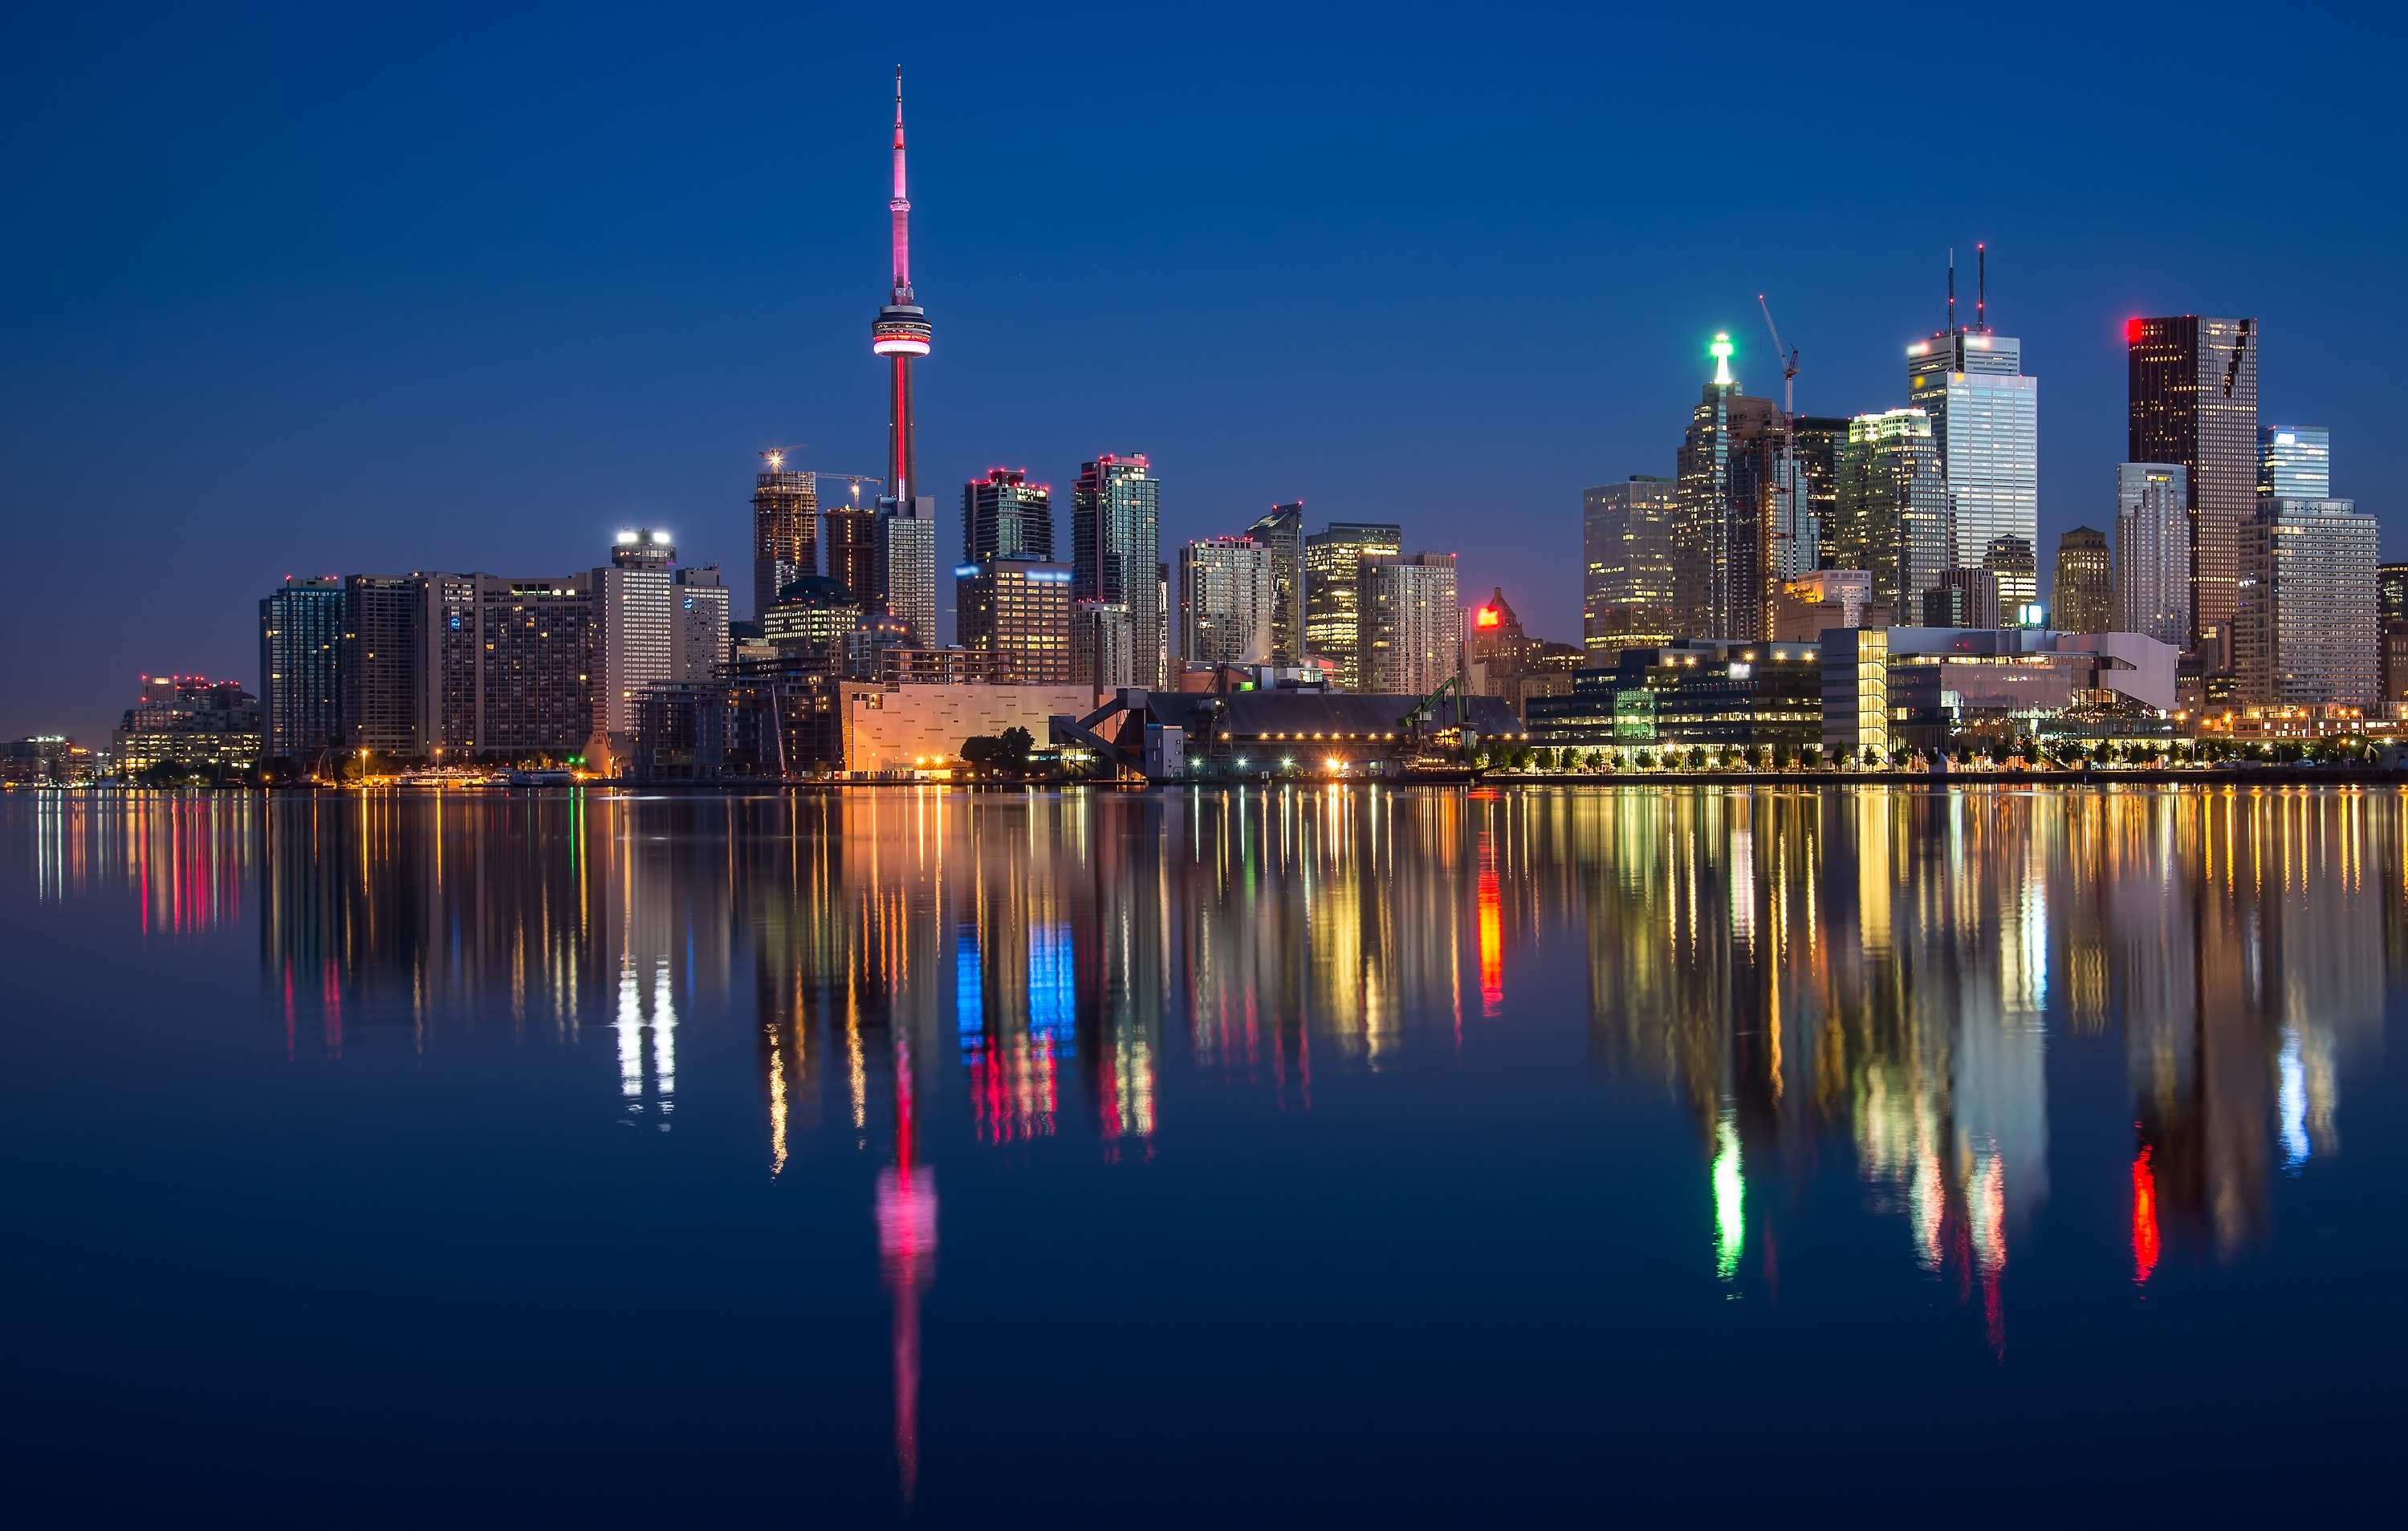

In [41]:
#Dashboard
dashboard=pn.Tabs(("Toronto",TorontoRow),("Welcome",WelcomeRow),("Shelter vs. Owned",SheltervsOwned),('Supply vs Demand', SupplyvDemand),
                  ("Top Expensive Neighbourhood",NeighbourhoodRow),("Yearly Market Analysis",FinalYearlyMarketColumn_bokeh),
                  ("Neighbourhood Analysis",Final_Neighbourhood))
dashboard.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [42]:
#neighbourhood_map().show()

In [43]:
# create_bar_chart(data, title, xlabel, ylabel, color)

# # Bar chart for 2001
#create_bar_chart(df_dwelling_units.loc[2001], "Dwelling Types in Toronto in 2001", "2001", "Dwelling Type Units", "red")

# # Bar chart for 2006
# create_bar_chart(df_dwelling_units.loc[2006], "Dwelling Types in Toronto in 2006", "2006", "Dwelling Type Units", "blue")

# # Bar chart for 2011
# create_bar_chart(df_dwelling_units.loc[2011], "Dwelling Types in Toronto in 2011", "2011", "Dwelling Type Units", "orange")

# # Bar chart for 2016
# create_bar_chart(df_dwelling_units.loc[2016], "Dwelling Types in Toronto in 2016", "2016", "Dwelling Type Units", "magenta")

In [44]:
# create_line_chart(data, title, xlabel, ylabel, color)

# # Line chart for owned dwellings
# create_line_chart(df_avg_costs["shelter_costs_owned"], "Average Monthly Shelter Cost for Owned Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "blue")

# # Line chart for rented dwellings
# create_line_chart(df_avg_costs["shelter_costs_rented"], "Average Monthly Shelter Cost for Rented Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "orange")

In [45]:
#average_house_value()

In [46]:
#average_value_by_neighbourhood()

In [47]:
#number_dwelling_types()

In [48]:
# average_house_value_snapshot()

In [49]:
#top_most_expensive_neighbourhoods()

In [50]:
#sunburts_cost_analysis()